In [1]:
import numpy as np
import os 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import polars as pl
import math
import gc
#from tqdm.notebook import tqdm
#tqdm.pandas()
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import multiprocessing
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import mean_squared_error 

# Definición de funciones

In [2]:
## Metrica de evaluación
def angular_dist_score1(az_true, zen_true, az_pred, zen_pred):
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    return np.average(np.abs(np.arccos(scalar_prod)))

In [12]:
sensor_geometry = pl.read_csv('./data/sensor_geometry.csv')
sensor_geometry.head()

sensor_id,x,y,z
i64,f64,f64,f64
0,-256.14,-521.08,496.03
1,-256.14,-521.08,479.01
2,-256.14,-521.08,461.99
3,-256.14,-521.08,444.97
4,-256.14,-521.08,427.95


In [13]:
fig = px.scatter_3d(sensor_geometry.to_pandas(), x='x', y='y', z='z', opacity=0.8, color='sensor_id')
fig.update_traces(marker = dict(size=2, symbol="circle"))
fig.update_layout(height=600, width=1200)
fig.show()

In [6]:
%%time
train_meta = pl.read_parquet('./data/train_meta.parquet')
## Cargar en memoria en arichivo con la información por batch.


CPU times: user 9.05 s, sys: 4.99 s, total: 14 s
Wall time: 3.03 s


In [7]:
train_meta.head()

batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
i64,i64,i64,i64,f64,f64
1,24,0,60,5.029555,2.087498
1,41,61,111,0.417742,1.549686
1,59,112,147,1.160466,2.401942
1,67,148,289,5.845952,0.759054
1,72,290,351,0.653719,0.939117


In [8]:
%%time
train_batch_1 = pl.read_parquet('./data/train/batch_1.parquet')
train_batch_1.head()


CPU times: user 1.24 s, sys: 419 ms, total: 1.66 s
Wall time: 455 ms


sensor_id,time,charge,auxiliary,event_id
i16,i64,f64,bool,i64
3918,5928,1.325,true,24
4157,6115,1.175,true,24
3520,6492,0.925,true,24
5041,6665,0.225,true,24
2948,8054,1.575,true,24


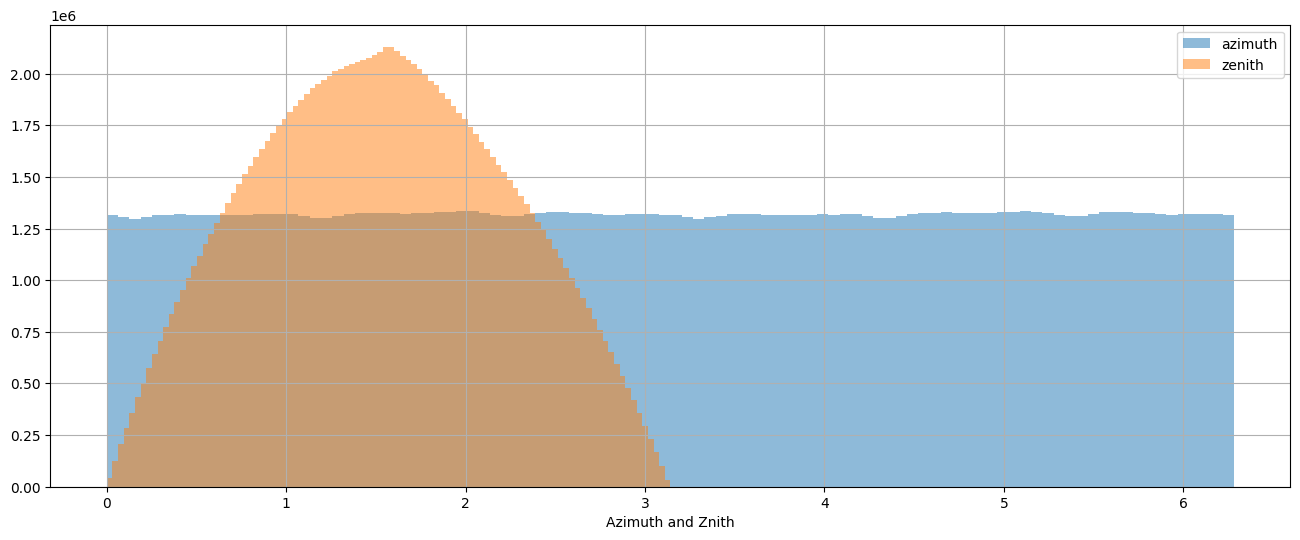

In [9]:
plt.figure(figsize=(16,6))
plt.hist(train_meta['azimuth'], bins=100, alpha=0.5, label='azimuth')
plt.hist(train_meta['zenith'], bins=100, alpha=0.5, label='zenith')
plt.grid()
plt.xlabel('Azimuth and Znith')
plt.legend()
plt.show()

In [7]:
# sensor_geometry = sensor_geometry.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
# train_batch_1 = train_batch_1.with_columns(pl.col('auxiliary').cast(pl.Int16))
# train_batch_1.join(sensor_geometry, on='sensor_id', how='left')
# train_batch_1.join(train_meta, on='event_id', how='left')

# Otra exploración de datos

Se selecciona el evento con id 24

In [6]:
tmp_eid=67
tmp_pulses = train_batch_1.filter(pl.col('event_id')==tmp_eid)
print(len(tmp_pulses))
tmp_pulses
tmp_pulses.drop('event_id')


142


sensor_id,time,charge,auxiliary
i16,i64,f64,bool
5060,6751,0.675,true
2420,7308,0.575,true
2420,7320,0.875,true
1968,7377,0.425,true
2989,7655,1.375,true
252,7716,1.475,true
2578,8403,2.175,true
971,8411,0.975,true
2578,8441,0.375,true


In [7]:
sensor_geometry = sensor_geometry.with_columns(pl.col('sensor_id').cast(pl.Int16))
tmp_pulses = tmp_pulses.join(sensor_geometry, on='sensor_id', how='left')
#Normalizando con la media
tmp_pulses = tmp_pulses.with_columns([(pl.col("x") - pl.mean(tmp_pulses["x"])).alias("x_mean"),
                                      (pl.col("y") - pl.mean(tmp_pulses["y"])).alias("y_mean"),
                                      (pl.col("z") - pl.mean(tmp_pulses["z"])).alias("z_mean")])
tmp_pulses = tmp_pulses.drop(["x", "y", "z"])
tmp_pulses

sensor_id,time,charge,auxiliary,event_id,x_mean,y_mean,z_mean
i16,i64,f64,bool,i64,f64,f64,f64
5060,6751,0.675,true,67,38.258521,-16.083732,-165.493873
2420,7308,0.575,true,67,-478.691479,47.816268,223.256127
2420,7320,0.875,true,67,-478.691479,47.816268,223.256127
1968,7377,0.425,true,67,-276.451479,-30.013732,-255.853873
2989,7655,1.375,true,67,624.308521,234.336268,-278.963873
252,7716,1.475,true,67,285.718521,-379.003732,358.226127
2578,8403,2.175,true,67,-231.591479,86.586268,-425.393873
971,8411,0.975,true,67,4.668521,-204.103732,373.906127
2578,8441,0.375,true,67,-231.591479,86.586268,-425.393873


# Vector base

In [8]:
zenith_tgt = train_meta.filter(pl.col("event_id") == tmp_eid)["zenith"][0]

In [9]:
azimuth_tgt = train_meta.filter(pl.col("event_id") == tmp_eid)["azimuth"][0]


In [12]:
vector_tgt = [np.cos(azimuth_tgt)*np.sin(zenith_tgt), 
              np.sin(azimuth_tgt)*np.sin(zenith_tgt),
              np.cos(zenith_tgt)]

base_v = np.array([-500,500])
x = base_v*vector_tgt[0]
y = base_v*vector_tgt[1]
z = base_v*vector_tgt[2]

vector_tgt_df = pl.DataFrame({'x': x, 'y': y, 'z': z})

In [13]:
tmp_aux_pulses = tmp_pulses.filter(pl.col("auxiliary")==True)
tmp_aux_pulses


sensor_id,time,charge,auxiliary,event_id,x_mean,y_mean,z_mean
i16,i64,f64,bool,i64,f64,f64,f64
5060,6751,0.675,true,67,38.258521,-16.083732,-165.493873
2420,7308,0.575,true,67,-478.691479,47.816268,223.256127
2420,7320,0.875,true,67,-478.691479,47.816268,223.256127
1968,7377,0.425,true,67,-276.451479,-30.013732,-255.853873
2989,7655,1.375,true,67,624.308521,234.336268,-278.963873
252,7716,1.475,true,67,285.718521,-379.003732,358.226127
2578,8403,2.175,true,67,-231.591479,86.586268,-425.393873
971,8411,0.975,true,67,4.668521,-204.103732,373.906127
2578,8441,0.375,true,67,-231.591479,86.586268,-425.393873


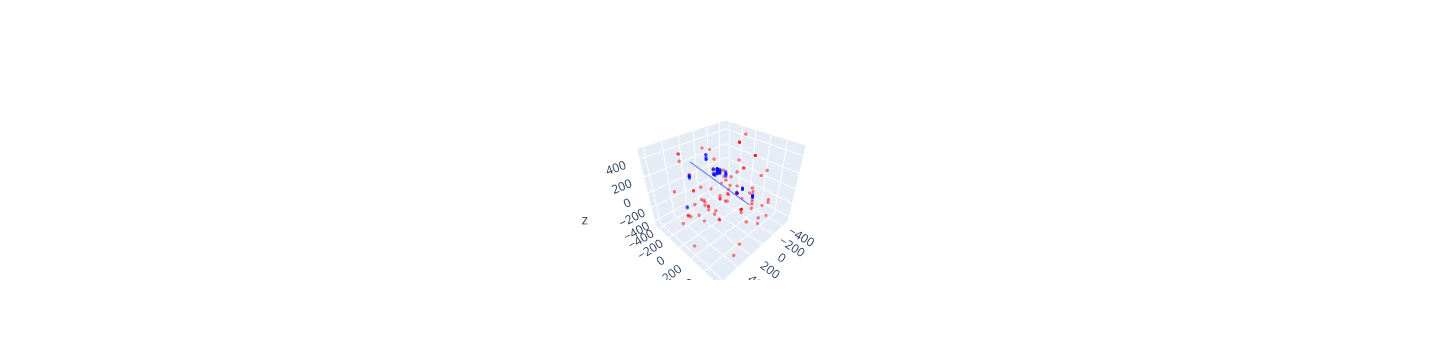

In [14]:
fig_auxiliary = px.scatter_3d(tmp_pulses.filter(pl.col("auxiliary")==True).to_pandas(),
                              x='x_mean', y='y_mean', z='z_mean', opacity=0.5, color_discrete_sequence=['red'])
fig_non_auxiliary = px.scatter_3d(tmp_pulses.filter(pl.col("auxiliary")==False).to_pandas(),
                               x='x_mean', y='y_mean', z='z_mean', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_tgt_df.to_pandas(), x="x", y="y", z="z")


fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data)
fig.show()

La figura muestra la linea que generan los ángulos con los pulsos 'verdaderos'. la mayoría de pulsos no tiene una línea clara como esta la mayoría de los pulsos no auxiliares aparecen como una línea vertical corta de puntos cercanos, no porque vengan directamente desde arriba sino debido a la estructura del detector

## Ajuste de curva con PCA, **modelo sencillo**

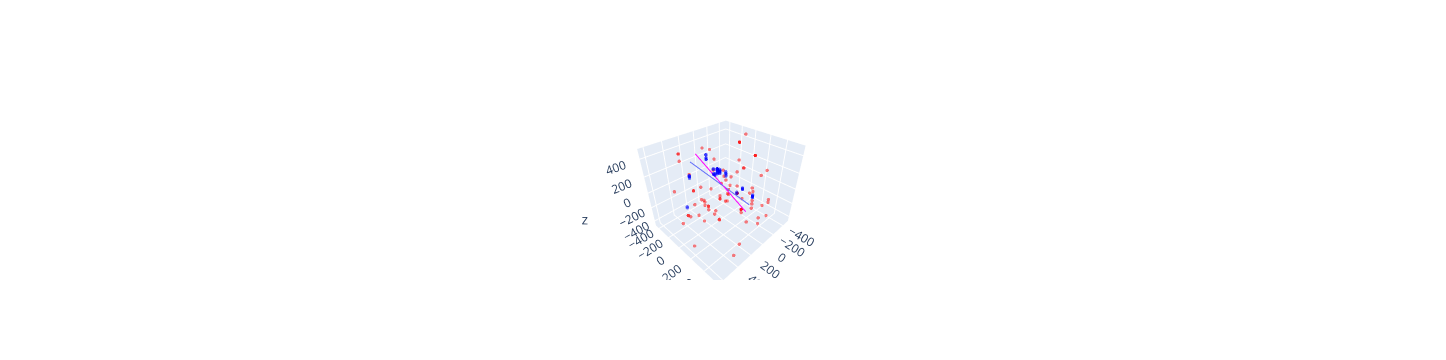

In [15]:
pca = PCA(n_components=1).fit(tmp_pulses.select(["x_mean", "y_mean", "z_mean", "charge"]).to_pandas())
vector_pca = pca.components_[0]
x_pca  = base_v*vector_pca[0]
y_pca  = base_v*vector_pca[1]
z_pca  = base_v*vector_pca[2]
vector_fit_df = pl.DataFrame({'x': x_pca, 'y': y_pca, 'z': z_pca})

fig_auxiliary = px.scatter_3d(tmp_pulses.filter(pl.col("auxiliary")==True).to_pandas(),
                              x='x_mean', y='y_mean', z='z_mean', opacity=0.5, color_discrete_sequence=['red'])
fig_non_auxiliary = px.scatter_3d(tmp_pulses.filter(pl.col("auxiliary")==False).to_pandas(),
                               x='x_mean', y='y_mean', z='z_mean', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_tgt_df.to_pandas(), x="x", y="y", z="z")
fig_fit_ln = px.line_3d(vector_fit_df.to_pandas(),x="x", y="y", z="z", color_discrete_sequence=['magenta'] )

fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data + fig_fit_ln.data)
fig.show()

In [16]:
zenith = np.arccos(vector_pca[2])
azimuth = np.arctan2(vector_pca[1], vector_pca[0])
if azimuth<0:
    azimuth = 2*np.pi + azimuth

print('Predictions:')
print(f'zenith: {zenith}')
print(f'azimuth: {azimuth}')
print('Target:')
print(f'zenith: {zenith_tgt}')
print(f'azimuth: {azimuth_tgt}')
print('Error:')
print(angular_dist_score1(azimuth_tgt, zenith_tgt, azimuth, zenith))

Predictions:
zenith: 0.5955780278032723
azimuth: 5.6568744990435205
Target:
zenith: 0.7590535704990591
azimuth: 5.845951997240071
Error:
0.20140388780386936


Se plantea un modelo base ajustando un vector solo a través de los pulsos 'verdaderos' si hay suficientes (> 15); de lo contrario, ajuste un vector a través de todos los datos. Además, se calcula el tiempo promedio de los pulsos 'verdaderos' en los lados negativo y positivo del vector y se cambia su dirección si apunta a la incorrecta. (los tiempos más bajos deberían estar en el lado positivo ya que se supone que apuntan a la fuente del neutrino). Este análisis se realiza solo para los pulsos 'verdaderos' ya que los tiempos de los pulsos auxiliares son demasiado ruidosos para este análisis sin mayor refinamiento.

# XGBoost

In [30]:
TRAIN_PATH = './data/train/'
META_PATH = './data/train_meta.parquet'
XGBZ = 100000

In [4]:
def get_train_batches(train_batch, sensor_geometry, train_meta, batch_id):
    train_batch = train_batch.with_columns(pl.col('auxiliary').cast(pl.Int16))
    sensors_df = sensor_geometry.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    train_df = train_batch.join(sensors_df, how='left', on='sensor_id')
    train_df = train_df.join(train_meta, how='left', on='event_id')
    train_df = train_df.drop(columns=['batch_id'])
    del train_batch
    del sensor_geometry
    return train_df

In [5]:
def get_test_df(test_batch, sensor_geometry, test_meta):
    test_batch = test_batch.with_columns(pl.col('auxiliary').cast(pl.Int16))
    sensors_df = sensor_geometry.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    test_df = test_batch.join(sensors_df, how='left', on='sensor_id')
    test_df = test_df.join(test_meta, how='left', on='event_id')
    test_df = test_df.drop(columns=['batch_id'])
    del test_meta
    del sensor_geometry
    return test_df

In [32]:
count = 0
model_xgb=None
params={'learning_rate': 0.007,
'tree_method': 'gpu_hist',
'refresh_leaf': True,
'reg_alpha': 3, # L1
'verbosity': 0}
for batch in os.listdir(TRAIN_PATH): 

    print(f'_______________________________________\nTraining batch: {batch}')  
    sensor_geometry = pl.read_csv('./data/sensor_geometry.csv')
    print('Sensors file loaded')
    train_meta = pl.read_parquet('./data/train_meta.parquet')
    print('Train meta loaded')
    train_batch = pl.read_parquet(os.path.join(TRAIN_PATH,batch))
    print(f'train_batch loaded')
    batch_df = get_train_batches(train_batch, sensor_geometry, train_meta, batch)
    print(f'Batch dataframe generated with shape: {batch_df.shape}')

    del sensor_geometry, train_meta
    X = batch_df.drop(['azimuth', 'zenith']).to_numpy()
    Y = batch_df[['azimuth', 'zenith']].to_numpy()
    x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
    #train_set = train_set.sample(frac=0.5)
    del batch_df, X, Y

    for start in tqdm(range(0, len(x_train), XGBZ)):
        model_xgb = xgboost.train(params=params,
                                  dtrain=xgboost.DMatrix(x_train[start:start+XGBZ], y_train[start:start+XGBZ]),
                                  xgb_model=model_xgb)
    params={'learning_rate': 0.007,
    'tree_method': 'gpu_hist',
    'updater':'refresh',
    'process_type': 'update',
    'refresh_leaf': True,
    'reg_alpha': 3, # L1
    'verbosity': 0}

    y_preds = model_xgb.predict(xgboost.DMatrix(x_val))
    print(f'Angular dist score for batch {count}: {angular_dist_score1(y_val[:,0], y_val[:,1], y_preds[:,0], y_preds[:,1])}')
    print(f'MSE for batch {count}: {mean_squared_error(y_val, y_preds)}')
    
    if(count==1):
        break
    else: 
        count+=1

_______________________________________
Training batch: batch_1.parquet
Sensors file loaded
Train meta loaded
train_batch loaded
Batch dataframe generated with shape: (32792416, 12)


  0%|          | 0/263 [00:00<?, ?it/s]

Angular dist score for batch 0: 1.2592657649558365
MSE for batch 0: 1.4439848949836436
_______________________________________
Training batch: batch_10.parquet
Sensors file loaded
Train meta loaded
train_batch loaded
Batch dataframe generated with shape: (33243258, 12)


  0%|          | 0/266 [00:00<?, ?it/s]

Angular dist score for batch 1: 1.3251545150135264
MSE for batch 1: 5.12379514420627


# Artificial Neural Network




## Data preprocessing

In [32]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred, batch_size=1):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    import numexpr as ne

    n = len(az_true)
    angle_sum = 0.0
    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        sa1 = np.sin(az_true[i:end]).astype(np.float32)
        ca1 = np.cos(az_true[i:end]).astype(np.float32)
        sz1 = np.sin(zen_true[i:end]).astype(np.float32)
        cz1 = np.cos(zen_true[i:end]).astype(np.float32)
        sa2 = np.sin(az_pred[i:end]).astype(np.float32)
        ca2 = np.cos(az_pred[i:end]).astype(np.float32)
        sz2 = np.sin(zen_pred[i:end]).astype(np.float32)
        cz2 = np.cos(zen_pred[i:end]).astype(np.float32)
        scalar_prod = ne.evaluate('sz1*sz2*(ca1*ca2 + sa1*sa2) + cz1*cz2')
        scalar_prod = np.clip(scalar_prod, -1, 1)
        angle_sum += np.sum(np.arccos(scalar_prod))
    return angle_sum / (n * batch_size) 

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = multiprocessing.cpu_count()
TRAIN_PATH = './data/train/'
META_PATH = './data/train_meta.parquet'
CHECKPOINT_NAME = './working/model_checkpoint.pth.tar'
EPOCHS = 30
INPUT_SIZE = 10
FEATURE_SIZE = 128
OUTPUT_SIZE = 2
LR = 0.001
BATCH_SIZE = 2048

In [16]:
def save_checkpoint(state, filename = 'my_checkpoint.pth.tar'):
    try:
        torch.save(state, filename)
        #print('Checkpoint saved succesfully')
    except:
        print('Error while sacing chekpoint')

In [17]:
def load_checkpoint(checkpoint, model): 
    try: 
        model.load_state_dict(checkpoint['state_dict'])
        print('Checkpoint importado exitosamente.')
    except: 
        print('Error en la importación del Checkpoint.')

In [7]:
class NeutrinosDataset(Dataset): 
    def __init__(self, df):
        self.data = df
        self.features = df.drop(['azimuth', 'zenith']).to_numpy()
        self.targets = df[['azimuth', 'zenith']].to_numpy()
        self.scaler = MinMaxScaler()
        self.scaler = self.scaler.fit(self.features)
        self.features = self.scaler.transform(self.features)
    
    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        targets = torch.tensor(self.targets[index], dtype=torch.float32)
        return   features, targets
                     

In [8]:
class MLP_Model(nn.Module):
    def __init__(self, input_size, output_size, feature_size):
        super(MLP_Model,self).__init__()
        self.feature_s2 =  feature_size//2
        self.feature_s3 = self.feature_s2//2
        self.feature_s4 = self.feature_s3//2
        self.feature_s5 = self.feature_s4//2

        self.mlp = nn.Sequential(
            nn.Linear(input_size, feature_size),
            nn.ReLU(True), 
            nn.Linear(feature_size, self.feature_s2), 
            nn.ReLU(True), 
            nn.Linear(self.feature_s2, self.feature_s3), 
            nn.ReLU(True), 
            nn.Linear(self.feature_s3, self.feature_s4), 
            nn.ReLU(True), 
            nn.Linear(self.feature_s4, self.feature_s5), 
            nn.ReLU(True), 
            nn.Linear(self.feature_s5, output_size)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [20]:
def train_model(train_loader, optimizer, loss_fn, model, scaler, device, epochs, chekpoint_path=None):
    model.train()
    p_bar = tqdm(range(epochs))
    #p_bar2 = tqdm(enumerate(train_loader))

    scores = []
    for epoch in p_bar:
        loss_ac =0.0
        
        for batch_idx, (features, targets) in enumerate(tqdm((train_loader))):
            features, targets = features.to(device), targets.to(device)
            with torch.cuda.amp.autocast():
                preds = model(features)
                loss = loss_fn(preds, targets)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_ac += loss.item()
            #p_bar2.set_postfix(loss=loss.item())
            #p_bar2.update()
    
        scores.append(loss_ac/len(train_loader))
        p_bar.set_postfix(loss=loss.item())
        if chekpoint_path is not None:
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, chekpoint_path)
    score = np.mean(scores)
    return score        

In [27]:
def predict(val_loader, model, device):
    model.eval()
    preds =[]
    trues = []
    with torch.no_grad():
        for features, targets in tqdm(val_loader):
            features = features.to(device)
            pred = model(features)
            preds.extend(pred.cpu().numpy())
            trues.extend(targets.cpu().numpy())
            y_hats = np.array(preds)
            y_trues = np.array(trues)
            
    az_true = y_trues.reshape(-1,2)[:,0]   
    zn_true = y_trues.reshape(-1,2)[:,1]   
    az_pred = y_hats.reshape(-1,2)[:,0]       
    zn_pred = y_hats.reshape(-1,2)[:,1] 

    score = angular_dist_score1(az_true=az_true, az_pred=az_pred, 
                               zen_pred=zn_pred, zen_true=zn_true
                               )        
    return y_trues, y_hats, score

In [12]:
def performance(val_loader, model, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            preds = model(features)
            preds =  scores.extend(pred.cpu().numpy())

            angular_dist_score(targets)


In [13]:
model = MLP_Model(INPUT_SIZE, OUTPUT_SIZE, FEATURE_SIZE).to(DEVICE)
print(model)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()

MLP_Model(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [18]:
load_checkpoint(torch.load('./working/model_checkpoint_4.pth.tar'), model)

Error en la importación del Checkpoint.


In [25]:
checkpoint = torch.load('./working/model_checkpoint_5.pth.tar')
model.load_state_dict(checkpoint['sate_dict'])

<All keys matched successfully>

In [27]:
%%time
print(f'Training on: {DEVICE}')
predictions = []
true_values = []
scores_mae = []
scores_training = []
count=0
for batch in os.listdir(TRAIN_PATH): 
    if(count>4): 
        print(f'_______________________________________\nTraining batch: {batch}')  
        sensor_geometry = pl.read_csv('./data/sensor_geometry.csv')
        print('Sensors file loaded')
        train_meta = pl.read_parquet('./data/train_meta.parquet')
        print('Train meta loaded')
        train_batch = pl.read_parquet(os.path.join(TRAIN_PATH,batch))
        print(f'train_batch loaded')
        batch_df = get_train_batches(train_batch, sensor_geometry, train_meta, batch)
        print(f'Batch dataframe generated with shape: {batch_df.shape}')

        del sensor_geometry, train_meta

        train_set, val_set = train_test_split(batch_df, test_size=0.2, random_state=42)
        #train_set = train_set.sample(frac=0.5)
        del batch_df
        dataset = NeutrinosDataset(train_set)   
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
        name=CHECKPOINT_NAME+str(count)
        scores = train_model(train_loader, optimizer, loss_fn, model, scaler, DEVICE, EPOCHS, name)
        scores_training.append(scores)
        #val_set = val_set.sample(frac=0.05)

        val_set = NeutrinosDataset(val_set)
        val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
        preds, true, a_score = predict(val_loader, model, DEVICE)
        predictions.append(preds)
        true_values.append(true)
        scores_mae.append(a_score)
        print(f'Mean Angular Error in batch {count}: {a_score}')
    if(count==5):
        break
    else: 
        count+=1



Training on: cuda
_______________________________________
Training batch: batch_103.parquet
Sensors file loaded
Train meta loaded
train_batch loaded
Batch dataframe generated with shape: (34527213, 12)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/6744 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Mean Angular Error in batch 5: 1.1929394602949426
CPU times: user 22min 33s, sys: 3min 26s, total: 26min
Wall time: 26min 26s


# Comparación de modelos:

In [10]:
model = MLP_Model(INPUT_SIZE, OUTPUT_SIZE, FEATURE_SIZE).to(DEVICE)
print(model)
checkpoint = torch.load('./working/model_checkpoint_5.pth.tar')
model.load_state_dict(checkpoint['sate_dict'])

MLP_Model(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=8, out_features=2, bias=True)
  )
)


<All keys matched successfully>

In [49]:
del test_batch, sensor_geometry, test_meta, test_df

NameError: name 'sensor_geometry' is not defined

In [24]:
test_batch = pl.read_parquet('./data/test/batch_660.parquet')
sensor_geometry  = pl.read_csv('./data/sensor_geometry.csv')
test_meta = pl.read_parquet('./data/train_meta.parquet')
test_df = get_train_batches(test_batch, sensor_geometry, test_meta,1)
test_df = test_df.filter(pl.col('event_id')==2144984130)


y_test = test_df[['azimuth', 'zenith']]
x_test = test_df.drop(['azimuth', 'zenith'])


In [42]:
y_test = y_test.to_numpy()
x_test = x_test.to_numpy()


In [28]:
%%time
model.eval()
vali_set = NeutrinosDataset(test_df)
       
val_loader = DataLoader(vali_set, batch_size=1, num_workers=NUM_WORKERS, pin_memory=True)
preds_ann, true, a_score = predict(val_loader, model, DEVICE)


  0%|          | 0/49 [00:00<?, ?it/s]

CPU times: user 50.7 ms, sys: 2.68 s, total: 2.74 s
Wall time: 3.34 s


In [43]:
%%time
preds_x = model_xgb.predict(xgboost.DMatrix(x_test))


CPU times: user 27.9 ms, sys: 2 µs, total: 27.9 ms
Wall time: 4.62 ms


In [45]:
a_score_x = angular_dist_score1(y_test[:,0], y_test[:,1], preds_x[:,0], preds_x[:,1])
nn_mse = mean_squared_error(true, preds_ann)
x_mse = mean_squared_error(y_test, preds_x)


In [48]:
print(f'Resultados:\n ___________________________\n')
print(f'ANN distancia media angular: {a_score}')
print(f'ANN MSE: {nn_mse}')
print(f'Tiempo de inferencia: 2.74 s')
print(f'ANN distancia media angular: {a_score_x}')
print(f'ANN MSE: {x_mse}')
print(f'Tiempo de inferencia: 27.9 ms')


Resultados:
 ___________________________

ANN distancia media angular: 1.2280142307281494
ANN MSE: 0.9676003456115723
Tiempo de inferencia: 2.74 s
ANN distancia media angular: 2.9817765751083116
ANN MSE: 6.034270573002302
Tiempo de inferencia: 27.9 ms
